In [48]:
import numpy as np

from keras.datasets import cifar10
import tensorflow.keras as keras
import tensorflow as tf

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data and Engineer Labels

In [29]:
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
animals_mapping = {
    0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0
}

In [30]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [31]:
def get_animals_arr(y_arr):
    animals_arr = np.zeros((y_arr.shape[0], 1))
    for i in range(y_arr.shape[0]):
        label = int(y_arr[i])
        animals_arr[i] = animals_mapping[label]
    return animals_arr

In [32]:
y_train_animals = get_animals_arr(y_train)
y_test_animals = get_animals_arr(y_test)

num_classes = len(np.unique(y_train))

## Define a Model

In [33]:
data_augmentation = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), 
     keras.layers.RandomRotation(0.1),
     keras.layers.RandomZoom(0.1)]
)

base_model = keras.applications.EfficientNetV2B1(include_top=False, weights='imagenet', input_shape=(240,240,3), 
                                                 classes=num_classes)

base_model.trainable = False

inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Lambda(lambda image: tf.image.resize(image, (240,240)))(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)

probs = tf.keras.layers.Dense(10, activation=('linear'), name='probs')(x)
animals = tf.keras.layers.Dense(1, activation=('linear'), name='animals')(x)

model = tf.keras.Model(inputs=inputs, outputs=[probs, animals])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda_3 (Lambda)              (None, 240, 240, 3)  0           ['input_8[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 240, 240, 3)  0           ['lambda_3[0][0]']               
                                                                                                  
 efficientnetv2-b1 (Functional)  (None, 8, 8, 1280)  6931124     ['sequential_3[0][0]']           
                                                                                            

In [34]:
model.compile(optimizer=keras.optimizers.Adam(), loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              keras.losses.BinaryCrossentropy(from_logits=True)], loss_weights=[1,1], 
              metrics={'probs': 'accuracy', 'animals': 'accuracy'})

In [35]:
epochs = 20
history = model.fit(x_train, [y_train, y_train_animals], validation_split=0.2, epochs=epochs, verbose=1)

Epoch 1/20
1250/1250 [==============================] - 149s 116ms/step - loss: 0.7991 - probs_loss: 0.6599 - animals_loss: 0.1392 - probs_accuracy: 0.7805 - animals_accuracy: 0.9450 - val_loss: 0.3686 - val_probs_loss: 0.3142 - val_animals_loss: 0.0544 - val_probs_accuracy: 0.8929 - val_animals_accuracy: 0.9816
Epoch 2/20
1250/1250 [==============================] - 143s 114ms/step - loss: 0.5927 - probs_loss: 0.4937 - animals_loss: 0.0990 - probs_accuracy: 0.8293 - animals_accuracy: 0.9604 - val_loss: 0.3324 - val_probs_loss: 0.2852 - val_animals_loss: 0.0471 - val_probs_accuracy: 0.9000 - val_animals_accuracy: 0.9833
Epoch 3/20
1250/1250 [==============================] - 142s 114ms/step - loss: 0.5514 - probs_loss: 0.4605 - animals_loss: 0.0909 - probs_accuracy: 0.8412 - animals_accuracy: 0.9639 - val_loss: 0.3213 - val_probs_loss: 0.2772 - val_animals_loss: 0.0440 - val_probs_accuracy: 0.9043 - val_animals_accuracy: 0.9840
Epoch 4/20
1250/1250 [==============================] - 14

In [37]:
results = model.evaluate(x_test, [y_test, y_test_animals])
classification_accuracy = results[3]
print(f'Model Loss: {round(results[0], 3)} \nModel Accuracy: {round(classification_accuracy, 3)}')

313/313 [==============================] - 23s 74ms/step - loss: 0.3005 - probs_loss: 0.2590 - animals_loss: 0.0416 - probs_accuracy: 0.9105 - animals_accuracy: 0.9853
Model Loss: 0.301 
Model Accuracy: 0.91


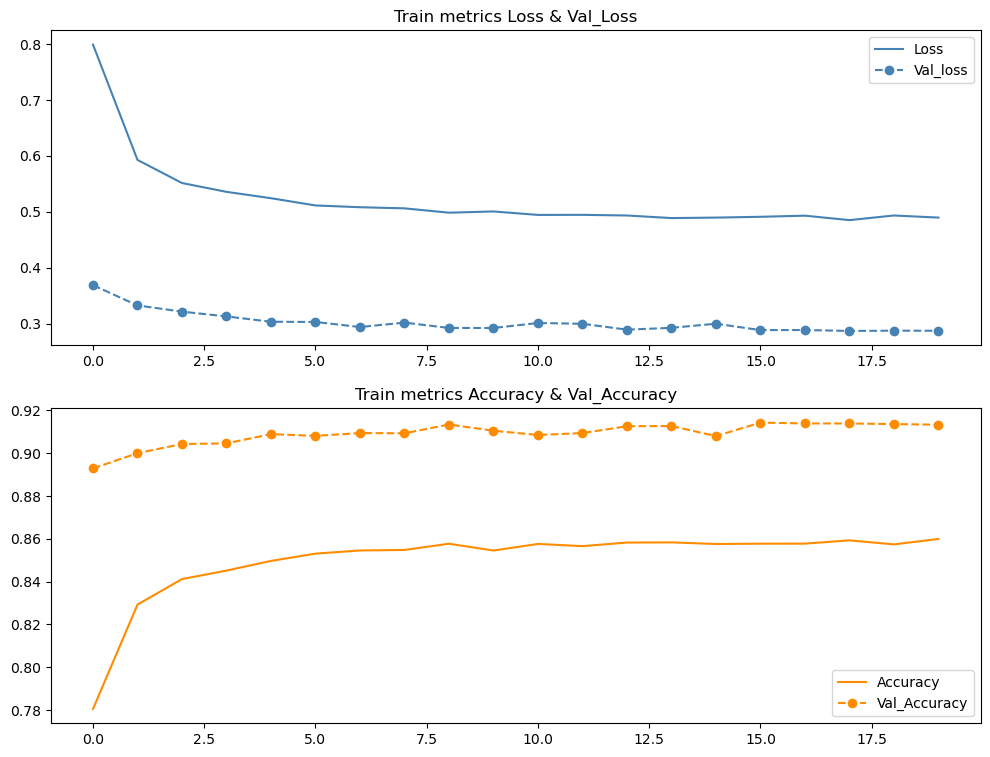

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9))


axes[0].set_title('Train metrics Loss & Val_Loss')
axes[0].plot(history.history['loss'], label='Loss', color='SteelBlue')
axes[0].plot(history.history['val_loss'], label='Val_loss', marker='o', linestyle='--', color='SteelBlue')
axes[0].legend()

axes[1].set_title('Train metrics Accuracy & Val_Accuracy')
axes[1].plot(history.history['probs_accuracy'], label='Accuracy', color='DarkOrange')
axes[1].plot(history.history['val_probs_accuracy'], label='Val_Accuracy', marker='o', linestyle='--', color='DarkOrange')
axes[1].legend()

plt.show()

In [42]:
base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                    keras.losses.BinaryCrossentropy(from_logits=True)], 
              loss_weights=[1,1],
              metrics={'probs': 'accuracy', 'animals': 'accuracy'})

history = model.fit(x_train, [y_train, y_train_animals], validation_split=0.2, epochs=10, verbose=1)

Epoch 1/10
1250/1250 [==============================] - 409s 316ms/step - loss: 0.2992 - probs_loss: 0.2521 - animals_loss: 0.0471 - probs_accuracy: 0.9133 - animals_accuracy: 0.9821 - val_loss: 0.1545 - val_probs_loss: 0.1378 - val_animals_loss: 0.0167 - val_probs_accuracy: 0.9529 - val_animals_accuracy: 0.9937
Epoch 2/10
1250/1250 [==============================] - 384s 307ms/step - loss: 0.1978 - probs_loss: 0.1711 - animals_loss: 0.0266 - probs_accuracy: 0.9400 - animals_accuracy: 0.9903 - val_loss: 0.1294 - val_probs_loss: 0.1137 - val_animals_loss: 0.0157 - val_probs_accuracy: 0.9597 - val_animals_accuracy: 0.9943
Epoch 3/10
1250/1250 [==============================] - 383s 306ms/step - loss: 0.1572 - probs_loss: 0.1378 - animals_loss: 0.0194 - probs_accuracy: 0.9525 - animals_accuracy: 0.9930 - val_loss: 0.1195 - val_probs_loss: 0.1070 - val_animals_loss: 0.0125 - val_probs_accuracy: 0.9637 - val_animals_accuracy: 0.9953
Epoch 4/10
1250/1250 [==============================] - 38

In [43]:
model.save('efficientnetb1-cifar.h5')

In [44]:
results = model.evaluate(x_test, [y_test, y_test_animals])
classification_accuracy = results[3]
print(f'Model Loss: {round(results[0], 3)} \nModel Accuracy: {round(classification_accuracy, 3)}')

313/313 [==============================] - 24s 76ms/step - loss: 0.1211 - probs_loss: 0.1070 - animals_loss: 0.0140 - probs_accuracy: 0.9700 - animals_accuracy: 0.9961
Model Loss: 0.121 
Model Accuracy: 0.97


313/313 [==============================] - 22s 71ms/step


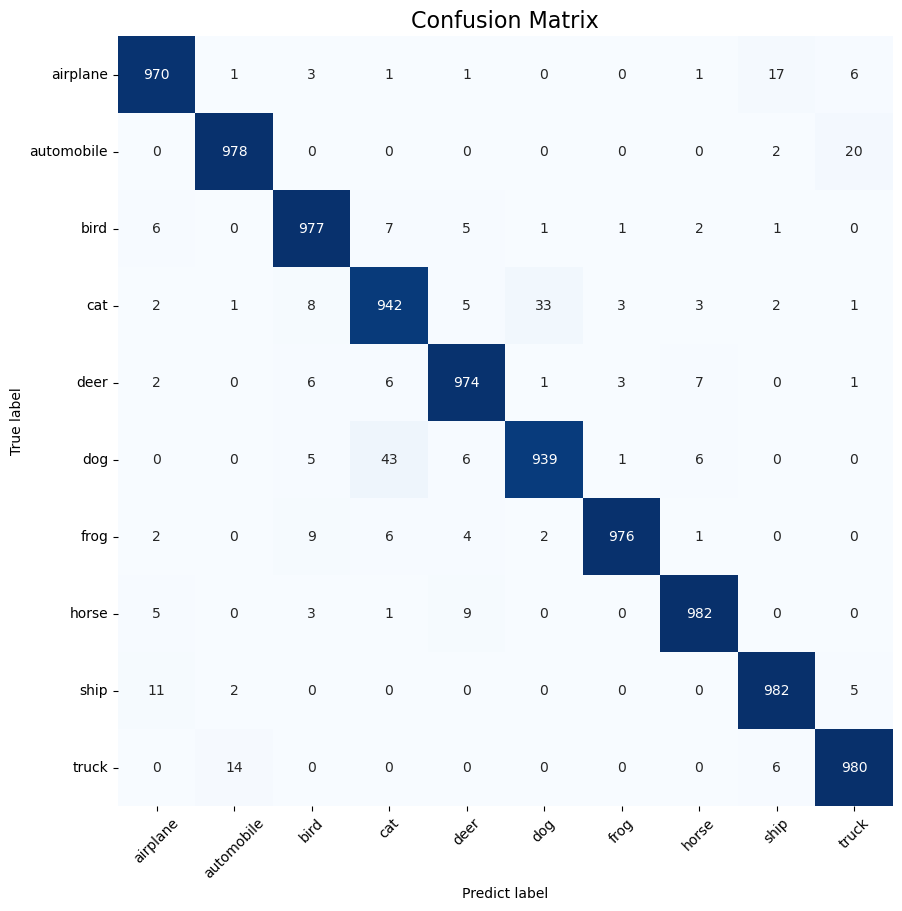

In [49]:
labels_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

pred_labels = model.predict(x_test)

pred_labels = [np.argmax(i) for i in pred_labels[0]]

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, 
            cbar=False, fmt='1d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xlabel('Predict label')
ax.set_ylabel('True label')
ax.set_xticklabels([label for label in labels_list], rotation=45)
ax.set_yticklabels(([label for label in labels_list]), rotation=0)
plt.show()